# **Introduction:**
### **a) Defining problem statement**
The objective of the project is to explore the dataset for RSNA Pneumonia Detection to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, the algorithm needs to automatically locate lung opacities on chest radiographs.

We start by exploring the DICOM data, we extract the meta information from the DICOM files and visualize the various features of the DICOM images, grouped by age, sex.

We will use data from URL: https://www.rsna.org/en/education/ai-resources-and-training/ai-image-challenge/RSNA-Pneumonia-Detection-Challenge-2018

### **b) Need of the study/project**
Diagnosing pneumonia requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. 

CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis.

### **c) Understanding business/social opportunity**
Automating Pneumonia screening in chest radiographs, providing affected area details through a bounding box. Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (ex. radiology). Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.


In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
#### code added below ####
os.chdir('/content/drive/My Drive/AIML/project')

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 63 Apr  5 16:08 kaggle.json
{"username":"sivaole","key":"89359c1c91ca6546c8a26934ffe7f857"}

In [0]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 5.3MB 28.2MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 112kB 61.3MB/s 
     |████████████████████████████████| 112kB 63.7MB/s 


In [0]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/110k [00:00<?, ?B/s]
100% 110k/110k [00:00<00:00, 15.0MB/s]
  0% 0.00/149k [00:00<?, ?B/s]
100% 149k/149k [00:00<00:00, 20.8MB/s]
  0% 0.00/146k [00:00<?, ?B/s]
100% 146k/146k [00:00<00:00, 19.6MB/s]
  0% 0.00/122k [00:00<?, ?B/s]
100% 122k/122k [00:00<00:00, 17.0MB/s]
  0% 0.00/113k [00:00<?, ?B/s]
100% 113k/113k [00:00<00:00, 16.1MB/s]
  0% 0.00/153k [00:00<?, ?B/s]
100% 153k/153k [00:00<00:00, 21.3MB/s]
  0% 0.00/92.5k [00:00<?, ?B/s]
100% 92.5k/92.5k [00:00<00:00, 13.2MB/s]
  0% 0.00/151k [00:00<?, ?B/s]
100% 151k/151k [00:00<00:00, 21.5MB/s]
  0% 0.00/119k [00:00<?, ?B/s]
100% 119k/119k [00:00<00:00, 16.2MB/s]
  0% 0.00/149k [00:00<?, ?B/s]
100% 149k/149k [00:00<00:00, 24.0MB/s]
  0% 0.00/103k [00:00<?, ?B/s]
100% 103k/103k [00:00<00:00, 14.6MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 10.2MB/s]
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 22.1MB/s]
  0% 0.00/133k [00:00<?, ?B/s]
100% 133k/133k [00:00<00:00, 18.8MB/s]
  0% 0.00/109k [0

In [0]:
from zipfile import ZipFile

with ZipFile('rsna-pneumonia-detection-challenge.zip', 'r') as z:
  z.extractall()

In [0]:
!pip install -q pydicom 
!pip install -q tqdm 
!pip install -q imgaug 

In [0]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
%matplotlib inline
import pydicom
import pydicom as dcm
#from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
import random
import math
import cv2
import json
from imgaug import augmenters as iaa
import glob 


import warnings
warnings.filterwarnings('ignore')

In [14]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.2


In [0]:
class_info_df = pd.read_csv('stage_2_detailed_class_info.csv')
train_lables_df = pd.read_csv('stage_2_train_labels.csv')

In [0]:
class_info_df.shape, train_lables_df.shape

((30227, 2), (30227, 6))

**Lets explore the data**

In [0]:
class_info_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


Class info data given detailed information about patient and the associated classes.

In [0]:
train_lables_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Train Lable dataset given information about the patient and the traget meta data info.

In [0]:
class_info_df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

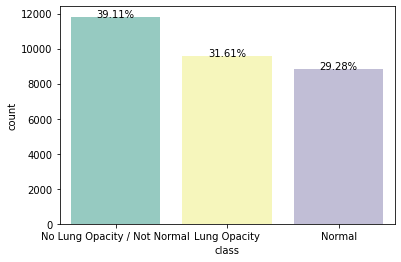

In [0]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [0]:
train_lables_df['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

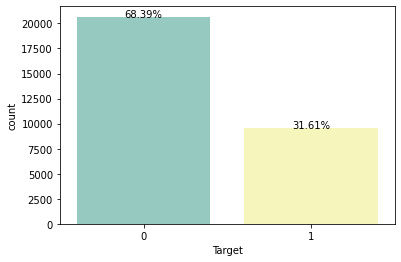

In [0]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(train_lables_df))
sns.countplot(train_lables_df['Target'],order = train_lables_df['Target'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

Lets check missing data

In [0]:
class_info_df.isnull().sum().sort_values(ascending=False)

class        0
patientId    0
dtype: int64

In [0]:
train_lables_df.isnull().sum().sort_values(ascending=False)

height       20672
width        20672
y            20672
x            20672
Target           0
patientId        0
dtype: int64

**Lets analyse the rows with NaN values**

In [0]:
df_NAN = train_lables_df[train_lables_df.isnull().any(axis=1)]

In [0]:
df_NAN.isnull().sum().sort_values(ascending=False)

height       20672
width        20672
y            20672
x            20672
Target           0
patientId        0
dtype: int64

In [0]:
df_NAN['Target'].value_counts()

0    20672
Name: Target, dtype: int64

We can see there are missing values in train lable dataset correspond to attributes height, width, x, y and the count matching with Traget value 0 which is No Lung Opacity / Not Normal and Normal.

**Do I need to treat missing value ??**

Lets merge both dataset using Patient ID as the merge criteria

In [0]:
s1 = pd.DataFrame(class_info_df['patientId'])
s2 = pd.DataFrame(train_lables_df['patientId'])

In [0]:
s1['patientIdMatch'] = np.where(s1['patientId'] == s2['patientId'], 'True', 'False') 
s1.head()

,patientId,patientIdMatch
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,True
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,True
2,00322d4d-1c29-4943-afc9-b6754be640eb,True
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,True
4,00436515-870c-4b36-a041-de91049b9ab4,True


In [0]:
s1.loc[s1['patientIdMatch'] == 'False']

,patientId,patientIdMatch


In [0]:
train_class_df1 = train_lables_df.merge(class_info_df, on='patientId', how='inner')

In [0]:
train_class_df1.shape

(37629, 7)

In [0]:
train_class_df = pd.concat([class_info_df, 
                        train_lables_df.drop('patientId',1)], 1)
train_class_df.shape

(30227, 7)

In [0]:
train_class_df.head()

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1


In [0]:
train_class_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


Lets Plot visually class and Target Distribution

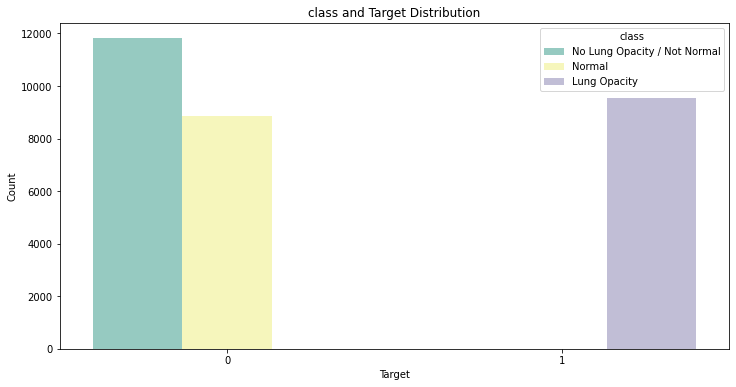

In [0]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Count': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Count',hue='class',data=df, palette='Set3')
plt.title("class and Target Distribution")
plt.show()

Target = 1 associated with class Lung Opacity and
Traget = 0 associated with class Normal or class: No Lung Opacity / Not Normal

Lets explore DICOM data for images

In [0]:
PATH = "/content/drive/My Drive/AIML/project/"
image_train_path = os.listdir(PATH+'stage_2_train_images/')
image_test_path = os.listdir(PATH+'stage_2_test_images/')
print("Number of images in train set:", len(image_train_path))
print("Number of images in test set:", len(image_test_path))

Number of images in train set: 26684
Number of images in test set: 3000


We can notice that number of train images present are less compared with information in class_info_df and train_lables_df i.e 30227. It might be that there are some duplicate entries in class_info_df and train_lables_df data sets. 

Lets explore duplicate data in train_class_df

In [0]:
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique()) 

Unique patientId in  train_class_df:  26684


We can confirm that number of unique patient ID's are equal to number of DICOM images in the train set. Then what entries are duplicated ? lets explore more...

In [0]:
tmp = train_class_df.groupby(['patientId','Target', 'class'])['patientId'].count()
df = pd.DataFrame(data={'Counts': tmp.values}, index=tmp.index).reset_index()
df

,patientId,Target,class,Counts
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,No Lung Opacity / Not Normal,1
1,000924cf-0f8d-42bd-9158-1af53881a557,0,Normal,1
2,000db696-cf54-4385-b10b-6b16fbb3f985,1,Lung Opacity,2
3,000fe35a-2649-43d4-b027-e67796d412e0,1,Lung Opacity,2
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1,Lung Opacity,2
...,...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,1,Lung Opacity,2
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,0,Normal,1
26681,fffc95b5-605b-4226-80ab-62caec682b22,0,No Lung Opacity / Not Normal,1
26682,fffcff11-d018-4414-971a-a7cefa327795,0,No Lung Opacity / Not Normal,1


We can see there are duplicate entries for some of the patients, lets explore how many such entries are exist for each Target and class combinations.

In [0]:
tmp = df.groupby(['Counts','Target','class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Counts', 'Target','Class', 'Entries']
df2

,Counts,Target,Class,Entries
0,1,0,No Lung Opacity / Not Normal,11821
1,1,0,Normal,8851
2,1,1,Lung Opacity,2614
3,2,1,Lung Opacity,3266
4,3,1,Lung Opacity,119
5,4,1,Lung Opacity,13


In [0]:
train_class_df[train_class_df['patientId'] == 'fffb2395-8edd-4954-8a89-ffe2fd329be3']

,patientId,class,x,y,width,height,Target
28983,fffb2395-8edd-4954-8a89-ffe2fd329be3,Lung Opacity,177.0,285.0,225.0,529.0,1
28984,fffb2395-8edd-4954-8a89-ffe2fd329be3,Lung Opacity,641.0,473.0,201.0,309.0,1


From the above resuts we can conclude that there are duplicate entries for some of the patients who are having Lung Opacity.

**Do we need to Handel these duplciate entries ???**

**Lets explore DICOM images information**

In [0]:
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join(PATH,"stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

We can see some useful data attributes from DICOM image metadata with values Like: sex, age, Body Part Examined, Rows, Columns etc

Lets visualise sample images

Plot DICOM images with Target = 1

In [0]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(len(data)//3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

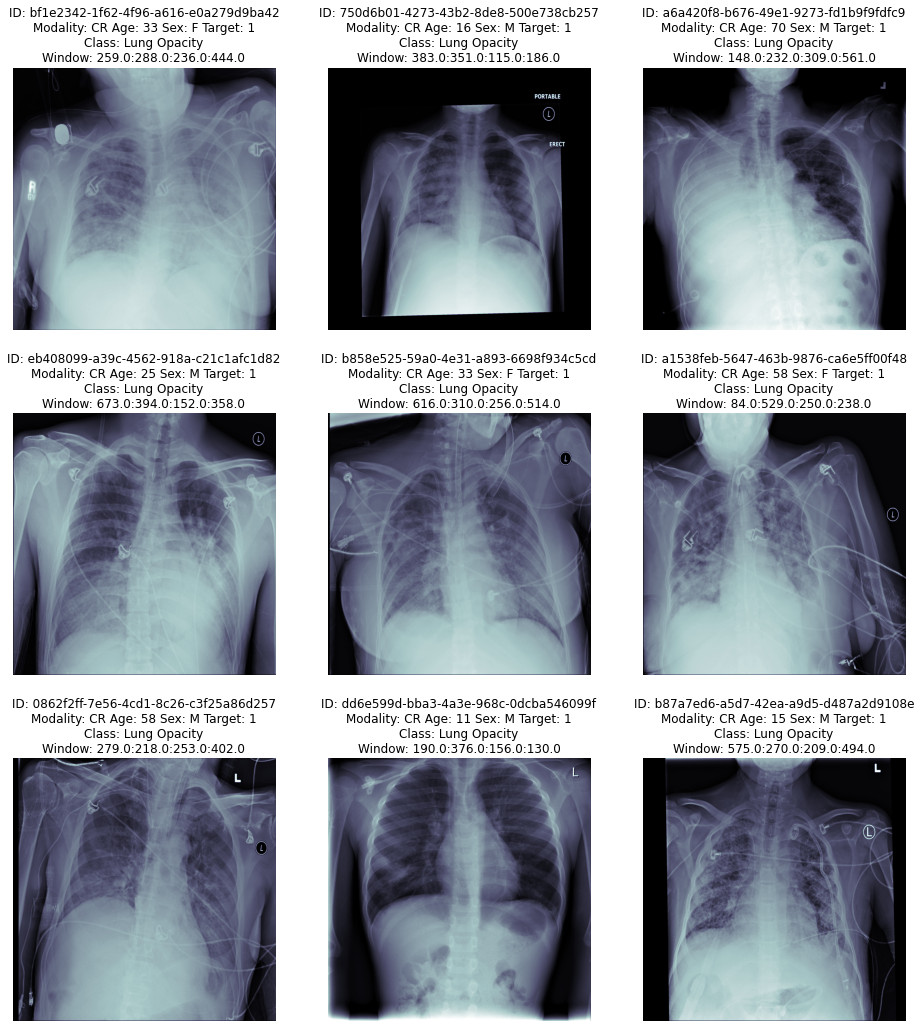

In [0]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

Lets superpose the bounding boxes by gathering all coordinates of the windows showing Lung Opacity on the same images.

In [0]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(len(data)//3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="red",alpha = 0.1))   
    plt.show()

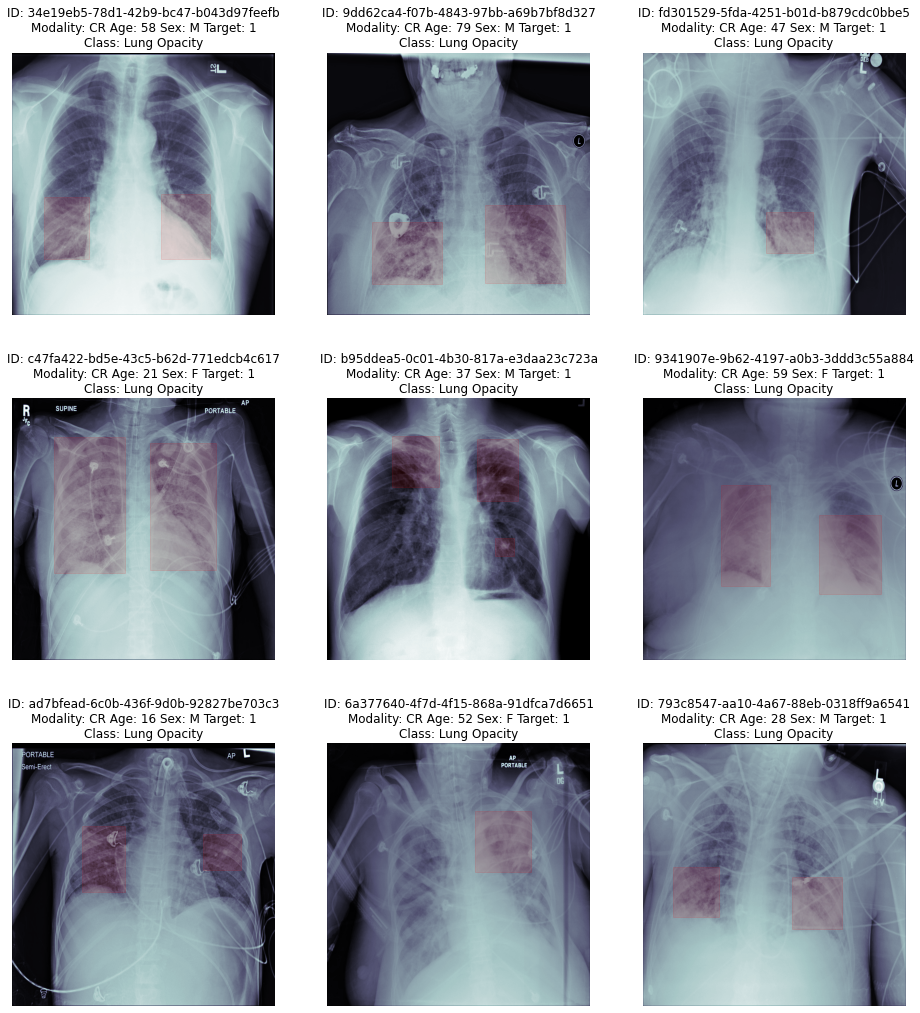

In [0]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

We can see multiple highlighted areas for some of the images with Lung Opacity.

Lets sample few normal or Target=0 images

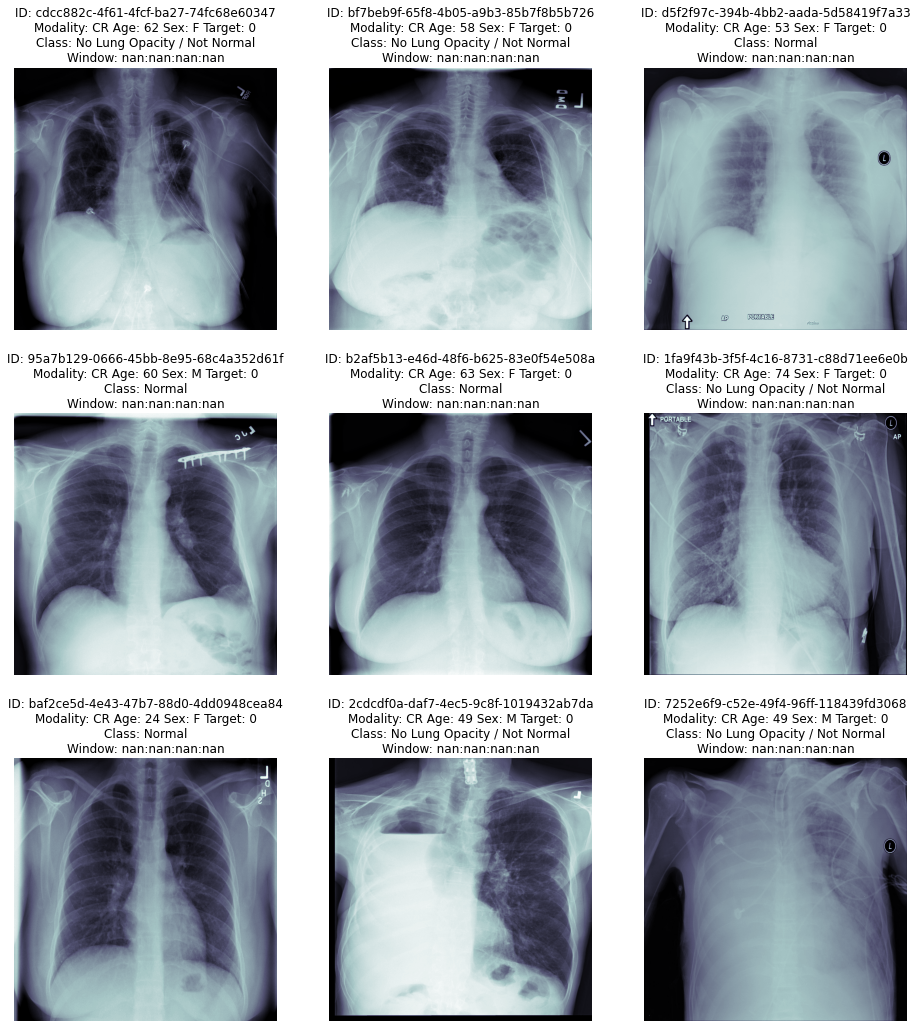

In [0]:
show_dicom_images(train_class_df[train_class_df['Target']==0].sample(9))

Lets create train and test DICOM datasets with selected metadata information.

In [0]:
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(PATH+data_path)
    for i, img_name in tqdm(enumerate(image_names)):
        imagePath = os.path.join(PATH,data_path,img_name)
        data_row_img_data = dcm.read_file(imagePath)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
        data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0]) 

In [0]:
process_dicom_data(train_class_df,'stage_2_train_images/')

In [0]:
train_class_df.tail()

,patientId,class,x,y,width,height,Target,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,185.0,298.0,228.0,379.0,1,CR,54,M,CHEST,AP,WSD,1024,1024,0.139
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal,NaN,NaN,NaN,NaN,0,CR,46,F,CHEST,PA,WSD,1024,1024,0.143
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal,NaN,NaN,NaN,NaN,0,CR,45,M,CHEST,PA,WSD,1024,1024,0.168
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity,570.0,393.0,261.0,345.0,1,CR,72,F,CHEST,AP,WSD,1024,1024,0.139
30226,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity,233.0,424.0,201.0,356.0,1,CR,72,F,CHEST,AP,WSD,1024,1024,0.139


In [0]:
train_class_df[train_class_df['patientId']=="fffb2395-8edd-4954-8a89-ffe2fd329be3"]

,patientId,class,x,y,width,height,Target,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
28983,fffb2395-8edd-4954-8a89-ffe2fd329be3,Lung Opacity,177.0,285.0,225.0,529.0,1,CR,46,M,CHEST,AP,WSD,1024,1024,0.168
28984,fffb2395-8edd-4954-8a89-ffe2fd329be3,Lung Opacity,641.0,473.0,201.0,309.0,1,CR,46,M,CHEST,AP,WSD,1024,1024,0.168


Lets create test data

In [0]:
test_class_df = pd.read_csv(PATH+'stage_2_sample_submission.csv')

In [0]:
test_class_df.head()

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


In [0]:
test_class_df = test_class_df.drop('PredictionString',axis=1)
process_dicom_data(test_class_df,'stage_2_test_images/')

In [0]:
test_class_df.head()

,patientId,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,CR,46,F,CHEST,PA,WSD,1024,1024,0.194
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,CR,22,F,CHEST,PA,WSD,1024,1024,0.143
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,CR,64,M,CHEST,PA,WSD,1024,1024,0.143
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,CR,75,F,CHEST,PA,WSD,1024,1024,0.143
4,00100a24-854d-423d-a092-edcf6179e061,CR,66,F,CHEST,AP,WSD,1024,1024,0.139


In [0]:
test_class_df.count()


patientId           3000
Modality            3000
PatientAge          3000
PatientSex          3000
BodyPartExamined    3000
ViewPosition        3000
ConversionType      3000
Rows                3000
Columns             3000
PixelSpacing        3000
dtype: int64

In [0]:
print("Unique patientId in  test_class_df: ", test_class_df['patientId'].nunique())

Unique patientId in  test_class_df:  3000


print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique()) 

**Lets Do EDA on DICOM Image metadata**

Lets create dataset with out duplicate patient information

In [0]:
train_class_df_d = train_class_df.drop_duplicates('patientId', keep='first')

In [0]:
train_class_df_d.count()

patientId           26684
class               26684
x                    6012
y                    6012
width                6012
height               6012
Target              26684
Modality            26684
PatientAge          26684
PatientSex          26684
BodyPartExamined    26684
ViewPosition        26684
ConversionType      26684
Rows                26684
Columns             26684
PixelSpacing        26684
dtype: int64

View Position is likely important since it describes the positioning of the patient when the radiograph is taken.

Note: I dont have any experience on Medical domain, analysis which is noted here is my own understanding based on data over view.

In [0]:
print("View Position: train:",train_class_df['ViewPosition'].unique(), "test:", test_class_df['ViewPosition'].unique())

View Position: train: ['PA' 'AP'] test: ['PA' 'AP']


In [0]:
train_class_df['ViewPosition'].value_counts()

AP    15297
PA    14930
Name: ViewPosition, dtype: int64

In [0]:
train_class_df_d['ViewPosition'].value_counts()

PA    14511
AP    12173
Name: ViewPosition, dtype: int64

In [0]:
test_class_df['ViewPosition'].value_counts()

PA    1618
AP    1382
Name: ViewPosition, dtype: int64

Lets see the data distribution with ViewPosition attribute

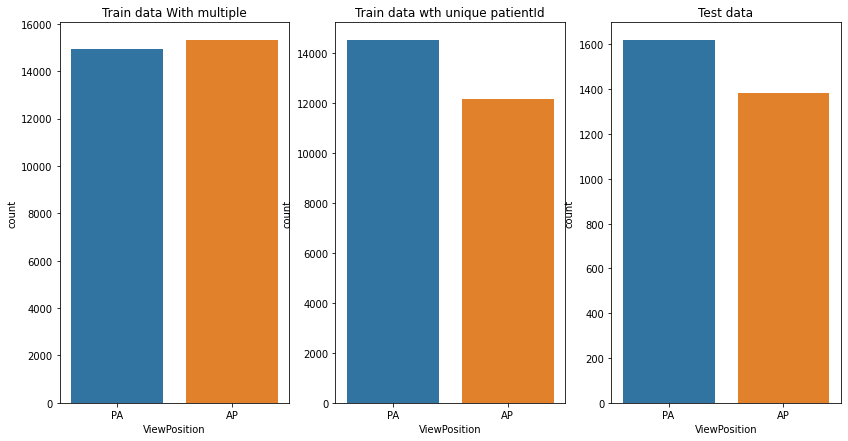

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.countplot(x='ViewPosition', data=train_class_df_d, ax=axes[1])
_ = p.set_title('Train data wth unique patientId')
p = sns.countplot(x='ViewPosition', data=test_class_df, ax=axes[2])
_ = p.set_title('Test data')

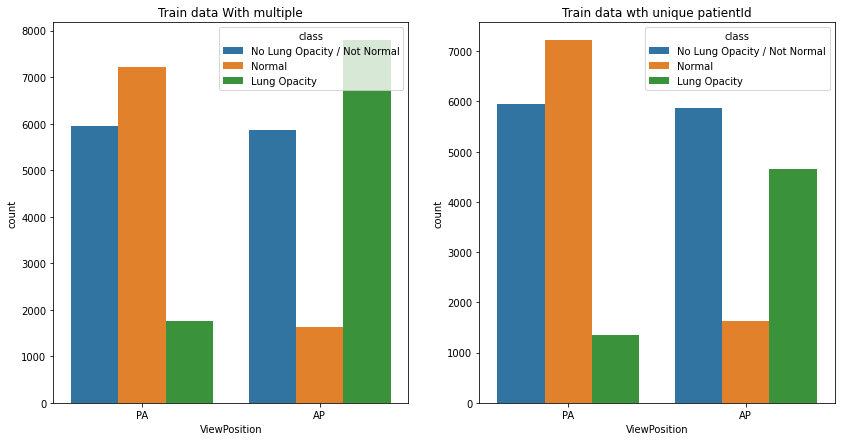

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='class', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.countplot(x='ViewPosition', hue='class', data=train_class_df_d, ax=axes[1])
_ = p.set_title('Train data wth unique patientId')

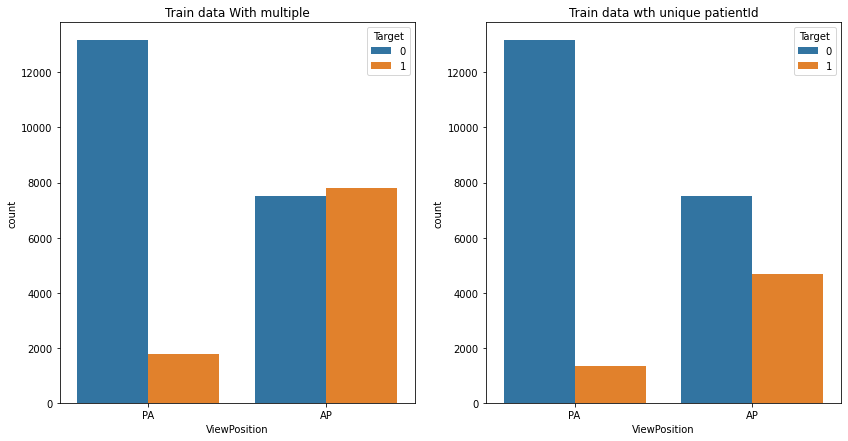

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='Target', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.countplot(x='ViewPosition', hue='Target', data=train_class_df_d, ax=axes[1])
_ = p.set_title('Train data wth unique patientId')

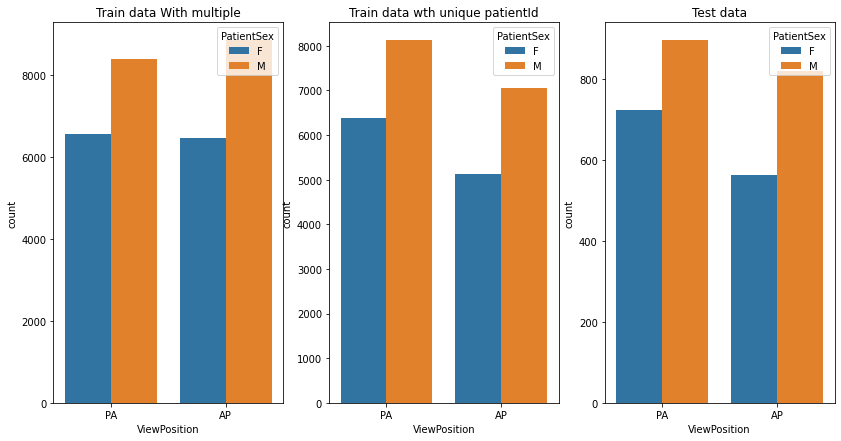

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='PatientSex', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.countplot(x='ViewPosition', hue='PatientSex', data=train_class_df_d, ax=axes[1])
_ = p.set_title('Train data wth unique patientId')
p = sns.countplot(x='ViewPosition', hue='PatientSex', data=test_class_df, ax=axes[2])
_ = p.set_title('Test data')

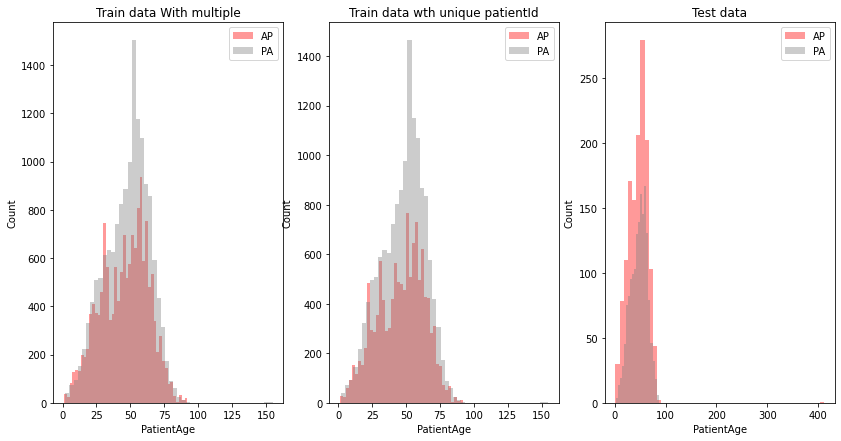

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(14, 7))

p = sns.distplot(train_class_df[train_class_df['ViewPosition']=='AP']['PatientAge'], hist=True, kde=False, color='red', label='AP', ax=axes[0])
p = sns.distplot(train_class_df[train_class_df['ViewPosition']=='PA']['PatientAge'], hist=True, kde=False, color='gray', label='PA', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Train data With multiple')

p = sns.distplot(train_class_df_d[train_class_df_d['ViewPosition']=='AP']['PatientAge'], hist=True, kde=False, color='red', label='AP', ax=axes[1])
p = sns.distplot(train_class_df_d[train_class_df_d['ViewPosition']=='PA']['PatientAge'], hist=True, kde=False, color='gray', label='PA', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Train data wth unique patientId')

p = sns.distplot(test_class_df[test_class_df['ViewPosition']=='AP']['PatientAge'], hist=True, kde=False, color='red', label='AP', ax=axes[2])
p = sns.distplot(test_class_df[test_class_df['ViewPosition']=='PA']['PatientAge'], hist=True, kde=False, color='gray', label='PA', ax=axes[2])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Test data')

Lets see the PatientAge distribution

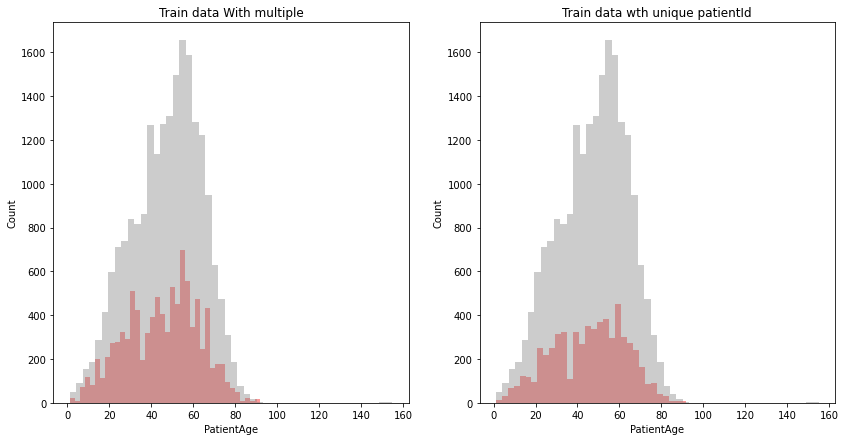

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(train_class_df[train_class_df['Target']==1]['PatientAge'], hist=True, kde=False, color='red', label='Target 1', ax=axes[0])
p = sns.distplot(train_class_df[train_class_df['Target']==0]['PatientAge'], hist=True, kde=False, color='gray', label='Target 0', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.set_title('Train data With multiple')

p = sns.distplot(train_class_df_d[train_class_df_d['Target']==1]['PatientAge'], hist=True, kde=False, color='red', label='Target 1', ax=axes[1])
p = sns.distplot(train_class_df_d[train_class_df_d['Target']==0]['PatientAge'], hist=True, kde=False, color='gray', label='Target 0', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.set_title('Train data wth unique patientId')

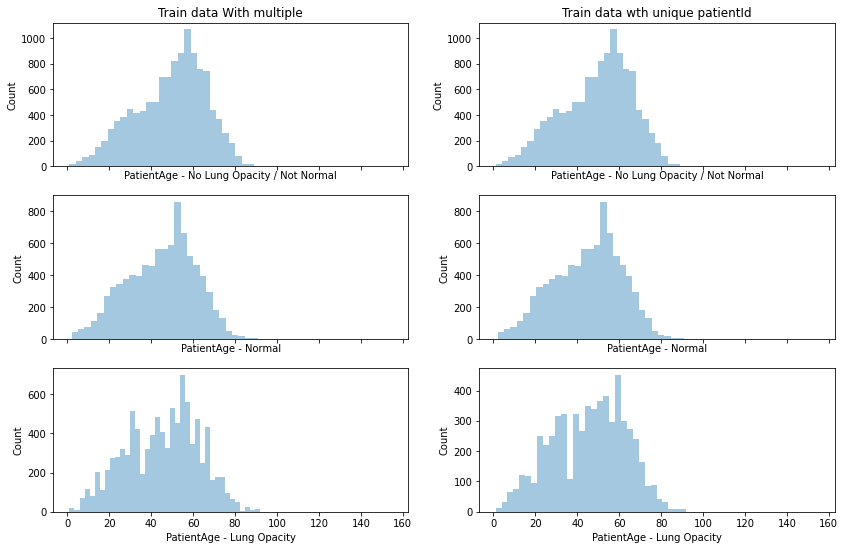

In [0]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)
for i, _class in enumerate(train_class_df['class'].dropna().unique()):
    p = sns.distplot(train_class_df[train_class_df['class']==_class]['PatientAge'], hist=True, kde=False, ax=axes[i, 0])
    _ = p.set_ylabel('Count')
    _ = p.set_xlabel(f'PatientAge - {_class}')
    if i == 0: p.set_title('Train data With multiple')
    
    p = sns.distplot(train_class_df_d[train_class_df_d['class']==_class]['PatientAge'], hist=True, kde=False, ax=axes[i, 1])
    _ = p.set_ylabel('Count')
    _ = p.set_xlabel(f'PatientAge - {_class}')
    if i == 0: p.set_title('Train data wth unique patientId')

Lets see the PatientSex data distribution

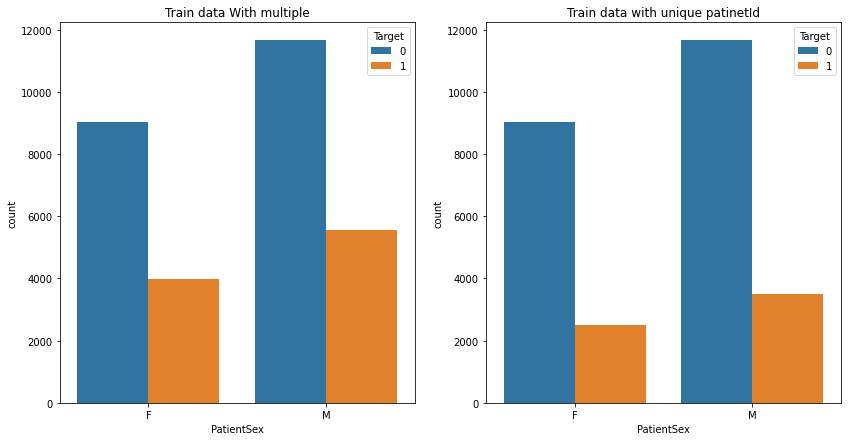

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='PatientSex', hue='Target', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.countplot(x='PatientSex', hue='Target', data=train_class_df_d, ax=axes[1])
_ = p.set_title('Train data with unique patinetId')

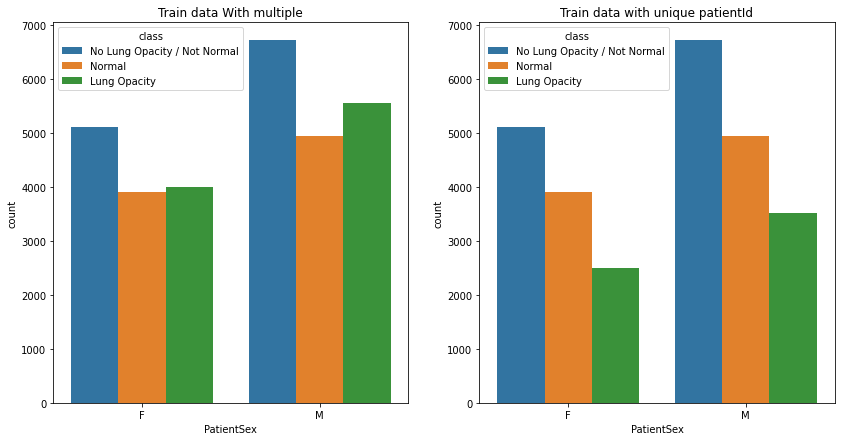

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='PatientSex', hue='class', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.countplot(x='PatientSex', hue='class', data=train_class_df_d, ax=axes[1])
_ = p.set_title('Train data with unique patientId')

**Lets check any out layers in the train data set**

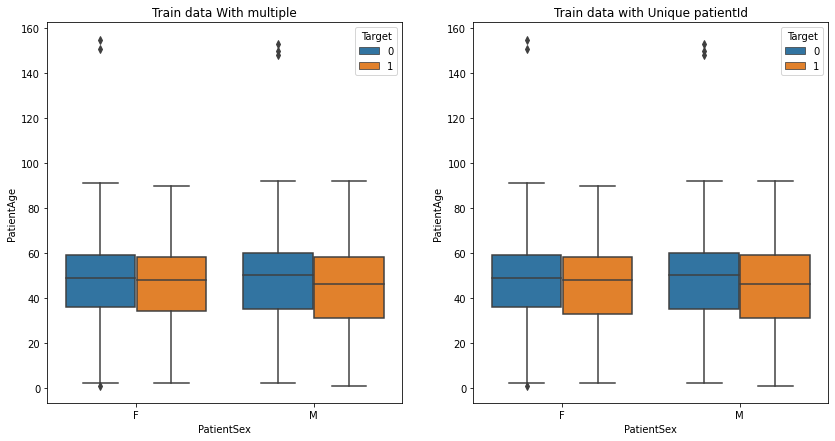

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='Target', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='Target', data=train_class_df_d, ax=axes[1])
_ = p.set_title('Train data with Unique patientId')

We can see there are out layers in the data, **do we need to drop out layer data ?**

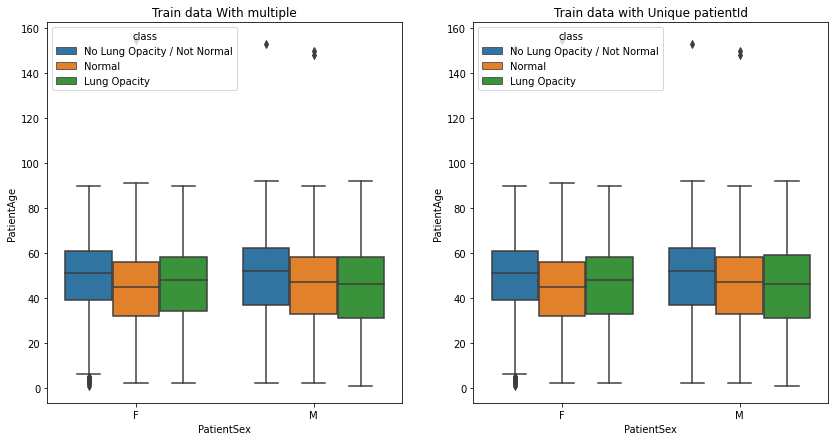

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='class', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='class', data=train_class_df_d, ax=axes[1])
_ = p.set_title('Train data with Unique patientId')

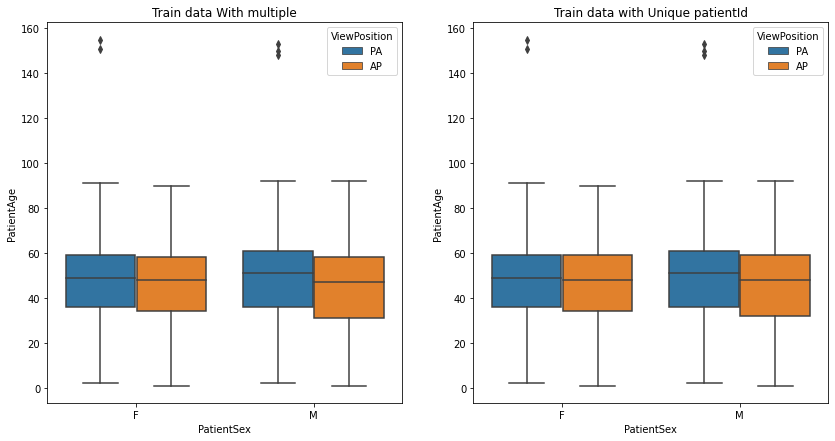

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='ViewPosition', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='ViewPosition', data=train_class_df_d, ax=axes[1])
_ = p.set_title('Train data with Unique patientId')